# STATS II - HW 1

## Setup

In [36]:
"""
Homework 1 Gender Wage Gap
Jackson School of Global Affairs                 
                                                 
 Created by Ardina Hasanbasri for GLBL 5021      
                                                 
Additional reference code and data used:        
Békés & Kézdi (2021) see more code below         
https://gabors-data-analysis.com/               
                                            
"""

# Note: Feel free to move this code to jupyter notebook if you prefer. 

#-----------------------------------#
# SETTING UP YOUR WORKSPACE #
# ----------------------------------#

# These imports are similar to lecture 1.2 code (feel free to add or delete)
import warnings
import numpy as np
import pandas as pd
import pyfixest as pf
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadstat
from statsmodels.nonparametric.smoothers_lowess import lowess
import statsmodels.formula.api as smf
from typing import List

cps= pd.read_csv("https://osf.io/download/4ay9x/")

C:\Users\nepoz\AppData\Local\Temp\ipykernel_4292\375386066.py:31: DtypeWarning: Columns (16) have mixed types. Specify dtype option on import or set low_memory=False.
  cps= pd.read_csv("https://osf.io/download/4ay9x/")


## 1.1

In [37]:
#-----------------------------------------------------------#
# Sample Selection and Creating New Data                    #
# ----------------------------------------------------------#

cps = cps.query("uhours>=20 & earnwke>0 & age>=24 & age<=64")

# Create variables 
cps["female"] = (cps.sex == 2).astype(int)
cps["w"] = cps["earnwke"] / cps["uhours"]
cps["lnw"] = np.log(cps["w"])

# Add demographic variables 
cps["white"] = (cps["race"] == 1).astype(int)
cps["afram"] = (cps["race"] == 2).astype(int)
cps["asian"] = (cps["race"] == 4).astype(int)
cps["hisp"] = (cps["ethnic"].notna()).astype(int)
cps["othernonw"] = (
    (cps["white"] == 0) & (cps["afram"] == 0) & (cps["asian"] == 0) & (cps["hisp"] == 0)
).astype(int)
cps["nonUSborn"] = (
    (cps["prcitshp"] == "Foreign Born, US Cit By Naturalization")
    | (cps["prcitshp"] == "Foreign Born, Not a US Citizen")
).astype(int)

cps["married"] = ((cps["marital"] == 1) | (cps["marital"] == 2)).astype(int)
cps["divorced"] = ((cps["marital"] == 3) & (cps["marital"] == 5)).astype(int)
cps["wirowed"] = (cps["marital"] == 4).astype(int)
cps["nevermar"] = (cps["marital"] == 7).astype(int)

cps["child0"] = (cps["chldpres"] == 0).astype(int)
cps["child1"] = (cps["chldpres"] == 1).astype(int)
cps["child2"] = (cps["chldpres"] == 2).astype(int)
cps["child3"] = (cps["chldpres"] == 3).astype(int)
cps["child4pl"] = (cps["chldpres"] >= 4).astype(int)

# Now let's select an industry to work with. 
# The code below shows the industry codes and their counts for first 25 rows. 
cps["ind02"].value_counts(dropna=False).to_frame()[1:25]
cps = cps.query('ind02=="Motor vehicles and motor vehicle equipment manufacturing (3361, 3362, 3363)"')

## 1.2

Text(0.5, 1.0, 'Wage by Age')

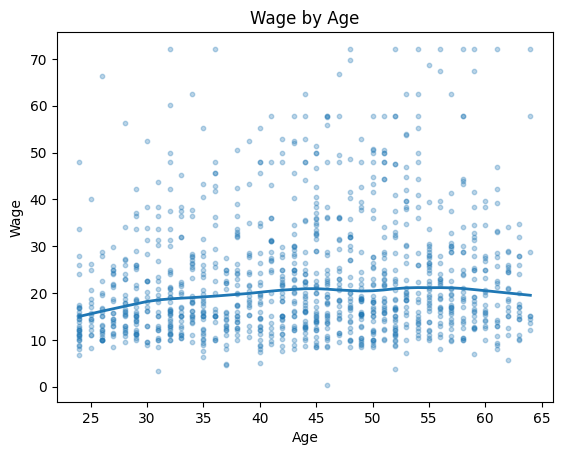

In [38]:
lowess_fit = lowess(
    endog=cps['w'],
    exog=cps['age'],
    frac=0.3   # smoothing parameter 
) 

plt.scatter(cps["age"], cps["w"], alpha=0.3, s=10)
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], linewidth=2)
plt.xlabel("Age")
plt.ylabel("Wage")
plt.title("Wage by Age")

Text(0.5, 1.0, 'Wage by Age')

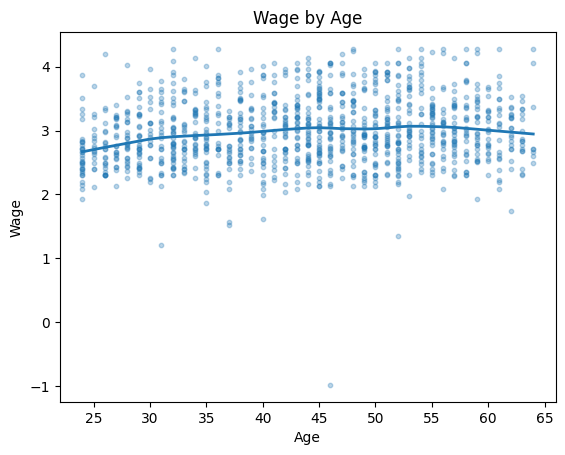

In [39]:
lowess_fit = lowess(
    endog=cps['lnw'],
    exog=cps['age'],
    frac=0.3   # smoothing parameter 
) 

plt.scatter(cps["age"], cps["lnw"], alpha=0.3, s=10)
plt.plot(lowess_fit[:, 0], lowess_fit[:, 1], linewidth=2)
plt.xlabel("Age")
plt.ylabel("Wage")
plt.title("Wage by Age")

We can see that wage slowly increases for older workers. However, after a certain age is reached, wage might start falling again.

## 1.3

In [40]:
cps["age2"] = cps["age"] ** 2
cps["age3"] = cps["age"] ** 3

In [41]:
group_A_codes = [31, 32, 33, 34, 35, 36, 37, 38]
group_B_codes = [39]
group_C_codes = [40, 41, 42]
group_D_codes = [43]
group_E_codes = [44, 45, 46]

mapping = {}
mapping.update({c: 'less_than_hs' for c in group_A_codes})
mapping.update({c: 'hs_grad' for c in group_B_codes})
mapping.update({c: 'some_college_associate' for c in group_C_codes})
mapping.update({c: 'college_grad' for c in group_D_codes})
mapping.update({c: 'post_grad' for c in group_E_codes})

cps['educ'] = cps['grade92'].map(mapping).fillna('other')


## 1.4

In [42]:
cps['educ'].value_counts(normalize=True)

educ
hs_grad                   0.413882
some_college_associate    0.295630
college_grad              0.154242
post_grad                 0.076264
less_than_hs              0.059983
Name: proportion, dtype: float64

Most people (41.4%) have high school as the highest level of education, 29.6% of people have some college/associate degree, 15.4% are college grads, 7.6% have post graduate degrees, and 6% of people don't even have high school education in the dataset.

## 2.1

In [43]:
reg_w_f = pf.feols("lnw~female", data=cps,vcov="HC1")
reg_w_fa = pf.feols("lnw~female+age", data=cps,vcov="HC1")
reg_w_faa = pf.feols("lnw~female+age+age2", data=cps,vcov="HC1")
reg4_w_faaa = pf.feols("lnw~female+age+age2+age3", data=cps,vcov="HC1")

In [44]:
pf.etable([reg_w_f, reg_w_fa, reg_w_faa, reg4_w_faaa],
          head_order="h",
          model_heads=["ln wage","ln wage", "ln wage", "ln wage"],
          labels={"Intercept": "Constant"}          
)

GT(_tbl_data=  level_0             level_1                       0                       1  \
0    coef              female  -0.213*** <br> (0.032)  -0.225*** <br> (0.032)   
1    coef                 age                           0.008*** <br> (0.001)   
2    coef                age2                                                   
3    coef                age3                                                   
4    coef            Constant   3.048*** <br> (0.018)   2.707*** <br> (0.056)   
5   stats        Observations                    1167                    1167   
6   stats           S.E. type                  hetero                  hetero   
7   stats       R<sup>2</sup>                   0.033                   0.059   
8   stats  Adj. R<sup>2</sup>                   0.032                   0.058   

                        2                       3  
0  -0.231*** <br> (0.032)  -0.231*** <br> (0.032)  
1   0.050*** <br> (0.011)      0.073 <br> (0.065)  
2  -0.000*** <br> (0.000)     -0.001 <br> (0.002)  
3                              0.000 <br> (0.000)  
4   1.859*** <br> (0.215)      1.548 <br> (0.862)  
5                    1167                    1167  
6                  hetero                  hetero  
7                   0.071                   0.071  
8                   0.068                   0.068  , _body=<great_tables._gt_data.Body object at 0x0000024355A0A810>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None), ColInfo(var='3', type=<ColInfoTypeEnum.default: 1>, column_label='(4)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000024355E3F850>, _spanners=Spanners([SpannerInfo(spanner_id='ln wage', spanner_level=1, spanner_label='ln wage', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2', '3'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x0000024354BE0950>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x0000024355B51210>, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000024355B51590>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='nor

### a)

female: On average females have 22.5% lower wages than men, holding age constant.

age: The average predicted increase in wages as age increases by one is 0.8% among people, controlling for their gender.

### b)

I would prefer the second regression if I was to analyse a possible gender gap, as it would allow me to capture a possible confounding variable (age)

## 2.2

In [45]:
reg_w_fe = pf.feols("lnw~female+educ", data=cps,vcov="HC1")

In [46]:
pf.etable([reg_w_fe],
          head_order="h",
          model_heads=["ln wage"],
          labels={"Intercept": "Constant"}          
)

GT(_tbl_data=  level_0                         level_1                       0
0    coef                          female  -0.191*** <br> (0.028)
1    coef                 educ[T.hs_grad]  -0.441*** <br> (0.043)
2    coef            educ[T.less_than_hs]  -0.784*** <br> (0.055)
3    coef               educ[T.post_grad]   0.363*** <br> (0.064)
4    coef  educ[T.some_college_associate]  -0.291*** <br> (0.044)
5    coef                        Constant   3.330*** <br> (0.038)
6   stats                    Observations                    1167
7   stats                       S.E. type                  hetero
8   stats                   R<sup>2</sup>                   0.285
9   stats              Adj. R<sup>2</sup>                   0.282, _body=<great_tables._gt_data.Body object at 0x0000024352E69110>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000024355A5C190>, _spanners=Spanners([SpannerInfo(spanner_id='ln wage', spanner_level=1, spanner_label='ln wage', spanner_units=None, spanner_pattern=None, vars=['0'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x0000024352E69190>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x0000024352E691D0>, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000024352E69050>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_top_color=OptionsInfo(scss=True, category='table', type='value', value='#A8A8A8'), table_border_right_style=OptionsInfo(scss=True, category='table', type='value', value='none'), table_border_right_width=OptionsInfo(scss=True, category='table', type='px', value='2px'), table_border_right_color=OptionsInfo(scss=True, category='table', type='value', value='#D3D3D3'), table_border_bottom_incl

On average, people have 78.4% lower wages when not being high school graduates compared to college grads. Similarly, it is 44.1% less for high school grads, 29.1% less for people with some college/associate degree, and 36.3% more for people with post-graduate degrees compared to college grads, controlling for their gender.

## 2.3

In [47]:
reg_w_f = pf.feols("lnw~female", data=cps,vcov="HC1")
reg_w_fa = pf.feols("lnw~female+age", data=cps,vcov="HC1")
reg_w_fae = pf.feols("lnw~female+age+educ", data=cps,vcov="HC1")

In [48]:
pf.etable([reg_w_f, reg_w_fa, reg_w_fae],
          head_order="h",
          model_heads=["ln wage","ln wage", "ln wage"],
          labels={"Intercept": "Constant"}          
)

GT(_tbl_data=   level_0                         level_1                       0  \
0     coef                          female  -0.213*** <br> (0.032)   
1     coef                             age                           
2     coef                 educ[T.hs_grad]                           
3     coef            educ[T.less_than_hs]                           
4     coef               educ[T.post_grad]                           
5     coef  educ[T.some_college_associate]                           
6     coef                        Constant   3.048*** <br> (0.018)   
7    stats                    Observations                    1167   
8    stats                       S.E. type                  hetero   
9    stats                   R<sup>2</sup>                   0.033   
10   stats              Adj. R<sup>2</sup>                   0.032   

                         1                       2  
0   -0.225*** <br> (0.032)  -0.202*** <br> (0.028)  
1    0.008*** <br> (0.001)   0.007*** <br> (0.001)  
2                           -0.454*** <br> (0.042)  
3                           -0.791*** <br> (0.055)  
4                            0.333*** <br> (0.065)  
5                           -0.300*** <br> (0.043)  
6    2.707*** <br> (0.056)   3.016*** <br> (0.059)  
7                     1167                    1167  
8                   hetero                  hetero  
9                    0.059                   0.309  
10                   0.058                   0.306  , _body=<great_tables._gt_data.Body object at 0x0000024355ACF110>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000024355E9EBD0>, _spanners=Spanners([SpannerInfo(spanner_id='ln wage', spanner_level=1, spanner_label='ln wage', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x0000024355E9E290>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x0000024355E9E490>, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000024355E9CED0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table'

The gender wage gap (the female coefficient) increases when adding age as a variable in the multilinear regression, indicating that as females get older, the relative difference between their wages and the wages of males will increase.

The gender wage gap decreases when adding the education category, indicating that some of the gap can be explained by differing education levels between men and women, with men potentially having higher levels of education (which can drive their wage growth).

Holding education constant and age constant, however, the wage gap is still 20.2%.

## 2.4

In [49]:
cps_fem = cps.loc[cps['female'] == 1]
cps_male = cps.loc[cps['female'] == 0]

In [50]:
reg_w_a_fem = pf.feols("lnw~age", data=cps_fem,vcov="HC1")
reg_w_a_male = pf.feols("lnw~age", data=cps_male,vcov="HC1")
reg_w_faaf = pf.feols("lnw~female+age+age*female", data=cps,vcov="HC1")

In [51]:
pf.etable([reg_w_a_fem, reg_w_a_male, reg_w_faaf],
          head_order="h",
          model_heads=["ln wage","ln wage", "ln wage"],
          labels={"Intercept": "Constant"}          
)

GT(_tbl_data=  level_0             level_1                      0                      1  \
0    coef                 age     0.002 <br> (0.002)  0.010*** <br> (0.001)   
1    coef              female                                                 
2    coef          age:female                                                 
3    coef            Constant  2.744*** <br> (0.114)  2.624*** <br> (0.065)   
4   stats        Observations                    319                    848   
5   stats           S.E. type                 hetero                 hetero   
6   stats       R<sup>2</sup>                  0.002                  0.042   
7   stats  Adj. R<sup>2</sup>                 -0.001                  0.041   

                       2  
0  0.010*** <br> (0.001)  
1     0.120 <br> (0.131)  
2  -0.008** <br> (0.003)  
3  2.624*** <br> (0.065)  
4                   1167  
5                 hetero  
6                  0.064  
7                  0.062  , _body=<great_tables._gt_data.Body object at 0x0000024355E55090>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000024355EBFE90>, _spanners=Spanners([SpannerInfo(spanner_id='ln wage', spanner_level=1, spanner_label='ln wage', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x0000024355EBF310>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x0000024355EBF390>, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000024355EBF3D0>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto', 'Oxygen', 'Ubuntu', 'Cantarell', 'Helvetica Neue', 'Fira Sans', 'Droid Sans', 'Arial', 'sans-serif']), table_font_size=OptionsInfo(scss=True, category='table', type='px', value='16px'), table_font_weight=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_style=OptionsInfo(scss=True, category='table', type='value', value='normal'), table_font_color=OptionsInfo(scss=True, category='table', type='value', value='#333333'), table_font_color_light=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_border_top_include=OptionsInfo(scss=False, category='table', type='boolean', value=True), table_border_top_style=OptionsInfo(scss=True, category='table', type='value', value='solid'), table_border_top_width=O

### 1)

As age increases, the average wage of women increases by 0.2%

### 2)

As age increases, the average wage of men increases by 1%

### 3)

As age increases, the average wage of men increases by 1%.

On average, females have 12% higher wages than male, holding age constant.

As age increases, the average change in wage will be 0.8 percentage points less than for men.

## 3.1

In [52]:
reg_w_f = pf.feols("lnw~female", data=cps,vcov="HC1")
reg_w_fae = pf.feols("lnw~female+age+educ", data=cps,vcov="HC1")
reg_w_faemo = pf.feols("lnw~female+age+educ+married+ownchild", data=cps,vcov="HC1")

In [53]:
pf.etable([reg_w_f, reg_w_fae, reg_w_faemo],
          head_order="h",
          model_heads=["ln wage","ln wage", "ln wage"],
          labels={"Intercept": "Constant"}          
)

GT(_tbl_data=   level_0                         level_1                       0  \
0     coef                          female  -0.213*** <br> (0.032)   
1     coef                             age                           
2     coef                 educ[T.hs_grad]                           
3     coef            educ[T.less_than_hs]                           
4     coef               educ[T.post_grad]                           
5     coef  educ[T.some_college_associate]                           
6     coef                         married                           
7     coef                        ownchild                           
8     coef                        Constant   3.048*** <br> (0.018)   
9    stats                    Observations                    1167   
10   stats                       S.E. type                  hetero   
11   stats                   R<sup>2</sup>                   0.033   
12   stats              Adj. R<sup>2</sup>                   0.032   

                         1                       2  
0   -0.202*** <br> (0.028)  -0.189*** <br> (0.028)  
1    0.007*** <br> (0.001)   0.007*** <br> (0.001)  
2   -0.454*** <br> (0.042)  -0.446*** <br> (0.043)  
3   -0.791*** <br> (0.055)  -0.794*** <br> (0.055)  
4    0.333*** <br> (0.065)   0.316*** <br> (0.066)  
5   -0.300*** <br> (0.043)  -0.294*** <br> (0.043)  
6                             0.075** <br> (0.028)  
7                               0.019 <br> (0.012)  
8    3.016*** <br> (0.059)   2.956*** <br> (0.063)  
9                     1167                    1167  
10                  hetero                  hetero  
11                   0.309                   0.317  
12                   0.306                   0.312  , _body=<great_tables._gt_data.Body object at 0x0000024355ECCE10>, _boxhead=Boxhead([ColInfo(var='level_0', type=<ColInfoTypeEnum.row_group: 3>, column_label='level_0', column_align='center', column_width=None), ColInfo(var='level_1', type=<ColInfoTypeEnum.stub: 2>, column_label='level_1', column_align='center', column_width=None), ColInfo(var='0', type=<ColInfoTypeEnum.default: 1>, column_label='(1)', column_align='center', column_width=None), ColInfo(var='1', type=<ColInfoTypeEnum.default: 1>, column_label='(2)', column_align='center', column_width=None), ColInfo(var='2', type=<ColInfoTypeEnum.default: 1>, column_label='(3)', column_align='center', column_width=None)]), _stub=<great_tables._gt_data.Stub object at 0x0000024355ED90D0>, _spanners=Spanners([SpannerInfo(spanner_id='ln wage', spanner_level=1, spanner_label='ln wage', spanner_units=None, spanner_pattern=None, vars=['0', '1', '2'], built=None)]), _heading=Heading(title=None, subtitle=None, preheader=None), _stubhead=None, _summary_rows=<great_tables._gt_data.SummaryRows object at 0x0000024355ED86D0>, _summary_rows_grand=<great_tables._gt_data.SummaryRows object at 0x0000024355ED8710>, _source_notes=['Significance levels: * p < 0.05, ** p < 0.01, *** p < 0.001. Format of coefficient cell:\nCoefficient \n (Std. Error)'], _footnotes=[], _styles=[], _locale=<great_tables._gt_data.Locale object at 0x0000024355ED8790>, _formats=[], _substitutions=[], _options=Options(table_id=OptionsInfo(scss=False, category='table', type='value', value=None), table_caption=OptionsInfo(scss=False, category='table', type='value', value=None), table_width=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_layout=OptionsInfo(scss=True, category='table', type='value', value='fixed'), table_margin_left=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_margin_right=OptionsInfo(scss=True, category='table', type='px', value='auto'), table_background_color=OptionsInfo(scss=True, category='table', type='value', value='#FFFFFF'), table_additional_css=OptionsInfo(scss=False, category='table', type='values', value=[]), table_font_names=OptionsInfo(scss=False, category='table', type='values', value=['-apple-system', 'BlinkMacSystemFont', 'Segoe UI', 'Roboto

## 3.2

As can be seen from the output above, gender, age, education levels and possibly marriage status as important in determining the wage gap between men and women in the automotive sector. Marriage is especially interesting as a variable. On average, married people earn more than unmarried people, holding other variables (including age) constant.

Before controlling for all these variables, the gender wage gap was 21.3%. After controlling, it was 18.9%.